In [ ]:
#this will take the extended train2 data set and create the following features, the data will then be split into train and test

#average sales last 3 6 9 months
#trend of sales in last 3 and 6 months - gradient of line
    #variance in sales of recent vs the considered period
# std in price in last month, m-2
    #days since first sale
#consistency of sales - continuous or stacatto- is there something every day or everynow and then?
# total sales for this shop in the last month, m-2
# total sales for this product in the last month

In [2]:
#load the data, add a few key variables, reduce to a specific product
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
dateCols = ['date']
train2=pd.read_csv("/home/cdsw/train_plus_not_imputted.csv",parse_dates=dateCols)
train2["TotalRevenue"]=train2.item_cnt_day*train2.item_price
train2["Month"]=train2.date.dt.month
train2["Year"]=train2.date.dt.year
train2['YM'] = train2['Year']*100+train2["Month"]

#create an average per month - see how it changes
sales_per_item_PM= train2.groupby(['item_id', "shop_id",'YM'])['item_cnt_day',"TotalRevenue" ].sum().reset_index()
sales_per_item_PM["AvPrice"]=sales_per_item_PM.TotalRevenue/sales_per_item_PM.item_cnt_day
sales_per_item_PM["id"]=sales_per_item_PM.item_id.astype("str")+"_"+sales_per_item_PM.shop_id.astype("str")

#pivot the data to get to get into a format required for predicting
sales_perM= sales_per_item_PM.pivot_table(index=["id"],columns="YM",values="item_cnt_day", fill_value=0).reset_index() 

In [8]:
#drop 201511 and 201512

sales=sales_perM.drop([sales_perM.columns[35],sales_perM.columns[36]],axis="columns")

#rename columns so sep= sales_minus1
df = pd.DataFrame({'M': range(1,34)})
df["Txt"]="SlsMth_min"+df.M.astype("str")
df2=df.sort_values(["M"],ascending=False)
nms2=list(df2.Txt)
nms1=[]
nms1.extend('i')
nms1.extend(nms2)
nms1.extend('T')
sales.columns=nms1
sales.rename(columns={'i': 'ids', 'T': 'Target'}, inplace=True)

#average of sales 3,6, 9 months prior
sales["Sls_Av3"]=  sales[["SlsMth_min3","SlsMth_min2","SlsMth_min1"]].mean(axis=1)
sales["Sls_Av6"]=sales.loc[: , "SlsMth_min6":"SlsMth_min1"].mean(axis=1)
sales["Sls_Av9"]=sales.loc[: , "SlsMth_min9":"SlsMth_min1"].mean(axis=1)

#sales trends of last 3,6,9 months
sales['STrend3'] = np.where(sales.SlsMth_min1==0, 0, (sales.SlsMth_min3-sales.SlsMth_min1)/sales.SlsMth_min1)
sales['STrend6'] = np.where(sales.SlsMth_min1==0, 0, (sales.SlsMth_min6-sales.SlsMth_min1)/sales.SlsMth_min1)
sales['STrend9'] = np.where(sales.SlsMth_min1==0, 0, (sales.SlsMth_min9-sales.SlsMth_min1)/sales.SlsMth_min1)

#variance of sales in last 3, 6, 9 months
sales["SVar3"]=sales.loc[:,"SlsMth_min3":"SlsMth_min1"].var(axis=1)
sales["SVar6"]=sales.loc[:,"SlsMth_min6":"SlsMth_min1"].var(axis=1)
sales["SVar9"]=sales.loc[:,"SlsMth_min9":"SlsMth_min1"].var(axis=1)
sales.head()



,ids,SlsMth_min33,SlsMth_min32,SlsMth_min31,SlsMth_min30,SlsMth_min29,SlsMth_min28,SlsMth_min27,SlsMth_min26,SlsMth_min25,...,Target,Sls_Av3,Sls_Av6,Sls_Av9,STrend3,STrend6,STrend9,SVar3,SVar6,SVar9
0,0_54,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000_25,1,0,0,0,0,0,1,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000_26,0,0,0,0,0,0,1,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000_29,0,0,0,0,0,0,0,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10000_30,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


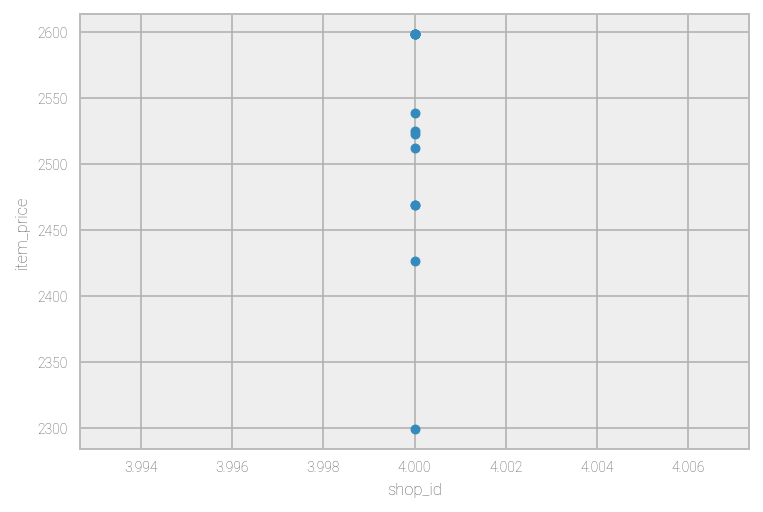

In [14]:
train2[(train2.item_id==3732)& (train2.YM==201309)&(train2.shop_id==4)].plot(kind="scatter",x="shop_id",y="item_price")

In [26]:
#other features require cuts of the original data and then merging

#standard dev of price in the last months
stdprice= train2.groupby(['item_id', "shop_id",'YM'])['item_price'].std().reset_index()
#set value to 0 where NaN
stdprice["item_price"]=stdprice.item_price.fillna(0)
stdprice["id"]=stdprice.shop_id.astype("str")+"_"+stdprice.item_id.astype("str")
stdprice2=stdprice.loc[stdprice.YM.isin([201508,201509,201510])]
stdprice3=stdprice2.pivot_table(index=["id"],columns="YM", values="item_price", fill_value=0).reset_index()
stdprice3.rename(columns={201508:"PStd1508",201509:"PStd1509",201510:"PStd1510"},inplace=True)
stdprice3.head()



YM,id,PVar1508,PVar1509,PVar1510
0,10_10042,0.0,0.0,0.0
1,10_10099,0.0,0.0,0.0
2,10_10115,0.0,0.0,0.0
3,10_10131,0.0,0.0,0.0
4,10_1017,0.0,0.0,0.0


{201508, 201509, 201510}